In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data: Verizon repair time

Verizon was an Incumbent Local Exchange Carrier (ILEC), responsible for maintaining land-line phone service in certain areas. Verizon also sold long-distance service, as did a number of competitors, termed Competitive Local Exchange Carriers (CLEC). When something went wrong, Verizon was responsible for repairs, and was supposed to make repairs as quickly for CLEC long-distance customers as for their own. The New York Public Utilities Commission (PUC) monitored fairness by comparing repair times for Verizon and different CLECs, for different classes of repairs and time periods.

The data is for one combination of CLEC, class of service, and period.

In [2]:
verizon_data = pd.read_csv('verizon.txt', sep='\t')
verizon_data.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


In [3]:
ilec_time = verizon_data[verizon_data.Group == 'ILEC'].Time.values
clec_time = verizon_data[verizon_data.Group == 'CLEC'].Time.values

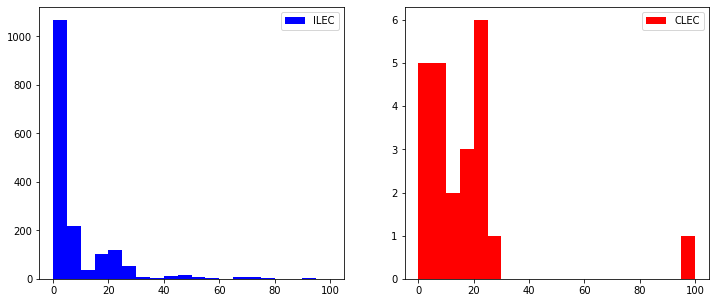

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(ilec_time, bins = 20, color = 'b', range = (0, 100), label = 'ILEC')
plt.legend()

plt.subplot(1,2,2)
plt.hist(clec_time, bins = 20, color = 'r', range = (0, 100), label = 'CLEC')
plt.legend()
plt.show()

## Percentile bootstrap

Standard Python libraries do not have implementation of bootstrap methods. The basic one – percentile bootstrap – is easy to implement ourselves. 

In [5]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

In [6]:
def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

### For a parameter of a single sample

In [7]:
np.random.seed(0)

ilec_median_scores = list(map(np.median, get_bootstrap_samples(ilec_time, 5000)))
clec_median_scores = list(map(np.median, get_bootstrap_samples(clec_time, 5000)))

print("95% confidence interval for the ILEC median repair time:",  percentile_interval(ilec_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  percentile_interval(clec_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [3.22  3.825]
95% confidence interval for the CLEC median repair time: [ 5.8  20.28]


### For a combination of parameters of two samples

In [8]:
print("Estimated difference between repait times:", np.median(clec_time) - np.median(ilec_time))

Estimated difference between repait times: 10.74


In [9]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(ilec_median_scores, clec_median_scores)))
print("95% confidence interval for the difference between median repair times:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for the difference between median repair times: [ 2.08  16.655]


In [86]:
aspirin_fav, aspirin_ttl = 104, 11037
placebo_fav, placebo_ttl = 189, 11034

aspirin_p = aspirin_fav/aspirin_ttl
placebo_p = placebo_fav/placebo_ttl

In [111]:
aspirin_fav, aspirin_ttl = 104, 11037
placebo_fav, placebo_ttl = 189, 11034

np.random.seed(0)

# aspirin_sample = np.zeros(aspirin_ttl)
# indices = np.random.choice(np.array(len(aspirin_sample)), size=aspirin_fav, replace=False)
# aspirin_sample[indices] = 1.0
# aspirin_sample = np.zeros(aspirin_ttl)
# aspirin_sample[:aspirin_fav] = 1

aspirin_sample = np.array([1]*104 + [0]*(11037-104))
np.random.shuffle(aspirin_sample)
assert aspirin_fav == np.sum(aspirin_sample), 'Something wrong with aspirin sample favs'
assert aspirin_ttl == len(aspirin_sample), 'Something wrong with aspiring sample lenght'

# placebo_sample = np.zeros(placebo_ttl)
# indices = np.random.choice(np.array(len(placebo_sample)), size=placebo_fav, replace=False)
# placebo_sample[indices] = 1.0
# placebo_sample = np.zeros(placebo_ttl)
# placebo_sample[:placebo_fav] = 1

placebo_sample = np.array([1]*189 + [0]*(11034-189))
np.random.shuffle(placebo_sample)
assert placebo_fav == np.sum(placebo_sample), 'Something wrong with placebo sample favs'
assert placebo_ttl == len(placebo_sample), 'Something wrong with placebo sample length'

aspirin_scores = list(map(lambda x: np.sum(x) / (len(x) - np.sum(x)), get_bootstrap_samples(aspirin_sample, 10000)))
placebo_scores = list(map(lambda x: np.sum(x) / (len(x) - np.sum(x)), get_bootstrap_samples(placebo_sample, 10000)))

odds_ratio_scores = list(map(lambda x: x[0] / x[1], zip(placebo_scores, aspirin_scores)))
CI = percentile_interval(odds_ratio_scores, 0.05)
print(CI)
print(round(CI[0], 4))

[1.44748508 2.35128256]
1.4475


In [100]:
round(placebo_p / (1 - placebo_p) / (aspirin_p / (1 - aspirin_p)), 4)

1.8321

In [107]:
aspirin_sample = np.zeros(aspirin_ttl)
aspirin_sample[:aspirin_fav] = 1
np.random.shuffle(aspirin_sample)
np.sum(aspirin_sample)

104.0

## BCa bootstrap
An external library https://pypi.org/project/bootstrap-stat/ actually has more exciting bootstrap methods implemented, including BCa bootstrap! The library is rather new and fresh, but seems to be working fine! Here are the examples, you'd have to install the library if you want to run them. 

In [11]:
from bootstrap_stat import bootstrap_stat as bp

### For a parameter of a single sample

In [12]:
dist_ilec = bp.EmpiricalDistribution(ilec_time)
dist_clec = bp.EmpiricalDistribution(clec_time)

In [13]:
print("95% confidence interval for the ILEC median repair time:", 
      bp.bcanon_interval(dist_ilec, np.median, ilec_time, B=5000))
print("95% confidence interval for the CLEC median repair time:", 
      bp.bcanon_interval(dist_clec, np.median, clec_time, B=5000))

95% confidence interval for the ILEC median repair time: (3.28, 3.78)
95% confidence interval for the CLEC median repair time: (5.8, 19.88)


### For a combination of parameters of two samples

In [14]:
joint_dist = bp.MultiSampleEmpiricalDistribution((ilec_time, clec_time))

def median_diff(two_sample_tuple):
    return np.median(two_sample_tuple[1]) - np.median(two_sample_tuple[0])

print("95% confidence interval for the difference between median repair times:", 
      bp.bcanon_interval(joint_dist, median_diff, (ilec_time, clec_time), B=5000))

95% confidence interval for the difference between median repair times: (2.1999999999999997, 16.45)


### Data: Failure times of CPU (Homework)

In [15]:
from numpy import loadtxt

In [16]:
data = loadtxt('failure_times.txt')

In [17]:
np.random.seed(0)

data_scores = list(map(np.mean, get_bootstrap_samples(data, 10000)))

print("95% confidence interval:",  percentile_interval(data_scores, 0.05))

95% confidence interval: [20909.66764706 28857.50404412]
